In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from scipy import stats
import matplotlib.pyplot as plt
import statsmodels.api as sm
from matplotlib import rcParams
from datetime import datetime
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from numpy.random import seed
seed(7)
import warnings
warnings.filterwarnings("ignore")

np.random.seed(7)

dataframe = pd.read_csv('international-airline-passengers.csv', parse_dates = ["Month"], index_col = ["Month"])
dataset = dataframe.values

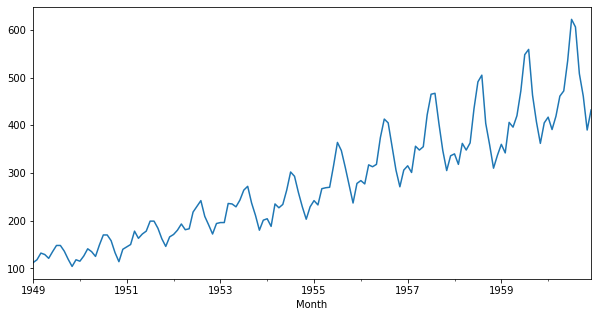

In [2]:
#震幅有隨時間越來越大的趨勢
rcParams['figure.figsize'] = 10,5
ps = dataframe.Passengers
ps.plot()
plt.show()

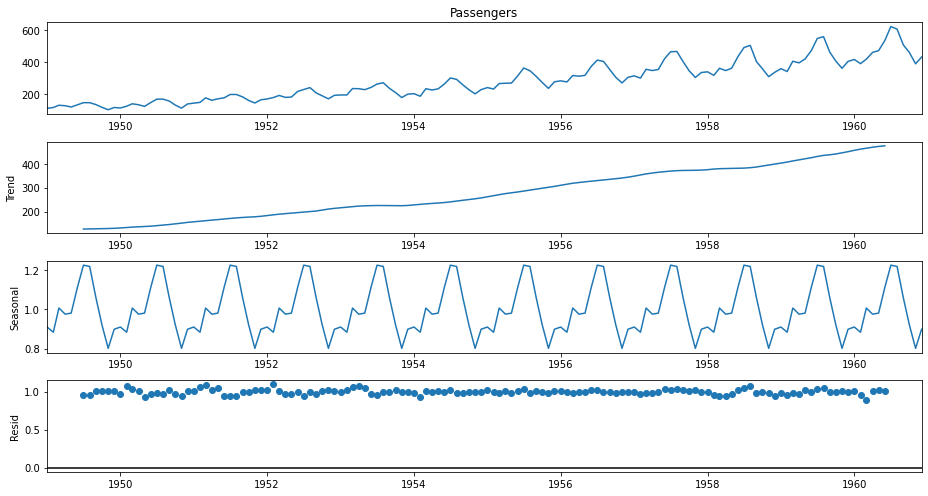

In [3]:
# 時間序列分解
# 由Seasonal列可知此資料具有週期性
rcParams['figure.figsize'] = 13,7
result_mul = seasonal_decompose(ps, model='multiplicative')
result_mul.plot()
plt.show()

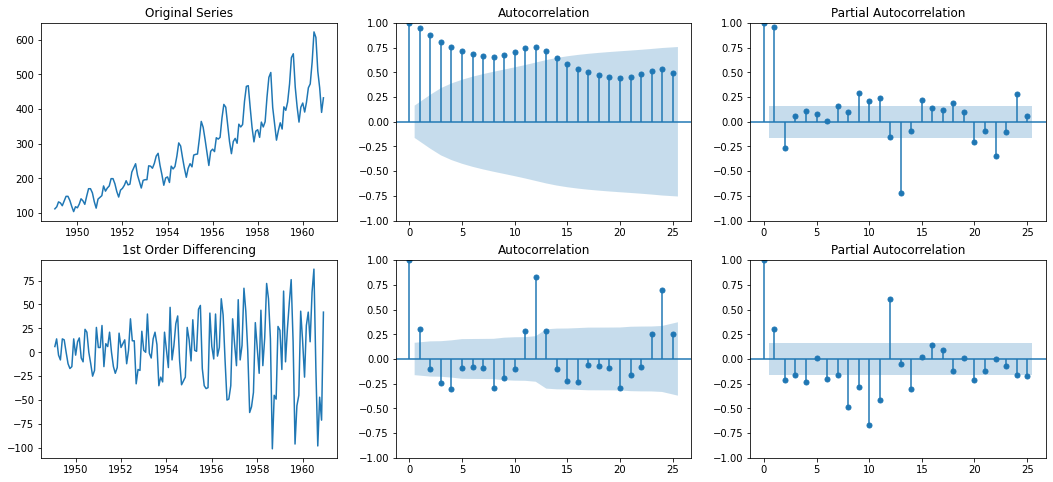

In [4]:
rcParams['figure.figsize'] = 18, 8

fig, axes = plt.subplots(2, 3, sharex=False)
axes[0, 0].plot(ps); axes[0, 0].set_title('Original Series')
plot_acf(ps, lags = 25, ax=axes[0, 1])
plot_pacf(ps, lags = 25, ax=axes[0, 2])
#拖尾超過10階以上，需進一步差分

# 一次差分(d=1)
axes[1, 0].plot(ps.diff().dropna()); axes[1, 0].set_title('1st Order Differencing')
plot_acf(ps.diff().dropna(), lags = 25, ax=axes[1, 1])
plot_pacf(ps.diff().dropna(), lags = 25, ax=axes[1, 2])
plt.show()
#經過一次差分後的ACF，每12階皆會出現一個極大值

In [5]:
import math
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from keras.callbacks import ModelCheckpoint
from keras.models import load_model

#定義一個為LSTM模型建立feature與label的函數
#利用已知的資料週期(12)，為LSTM建立feature
look_back = 12
def create_dataset(dataset, look_back):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back):look_back-1, 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

Using TensorFlow backend.


In [6]:
np.random.seed(7)

dataframe = pd.read_csv('international-airline-passengers.csv', parse_dates = ["Month"], index_col = ["Month"])
dataset = dataframe.values

#資料正規化
sc = MinMaxScaler()
dataset = sc.fit_transform(dataset)

#2/3的資料作為訓練集，其餘做為測試集
train_size = int(len(dataset)*0.67)
test_size = len(dataset)-train_size
train, test = dataset[0:train_size, :], dataset[train_size:, :]

look_back = 12
trainX, trainY = create_dataset(train, look_back)
testX, testY  = create_dataset(test, look_back)

#將資料轉換為(樣本數, 特徵time step(即look back), 特徵數)
trainX = np.reshape(trainX,(trainX.shape[0], trainX.shape[1], 1))
testX = np.reshape(testX,(testX.shape[0], testX.shape[1], 1))

In [7]:
tf.random.set_seed(7)
model = Sequential()
model.add(LSTM(200, return_sequences=True,
               input_shape=(trainX.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(200, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(200))
model.add(Dropout(0.2))
model.add(Dense(1))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 2, 200)            161600    
_________________________________________________________________
dropout_1 (Dropout)          (None, 2, 200)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 2, 200)            320800    
_________________________________________________________________
dropout_2 (Dropout)          (None, 2, 200)            0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 200)               320800    
_________________________________________________________________
dropout_3 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                

In [8]:
model.compile(loss = 'mse', optimizer = 'adam')

In [9]:
#利用ModelCheckpoint套件，找出預測誤差最小的權重值，並存成my_model.h5
mc = ModelCheckpoint("my_model.h5", monitor="loss",
                     mode="min", verbose=1,
                     save_best_only=True)
history = model.fit(trainX, trainY,
                    epochs=100, batch_size=10, verbose=1, callbacks=[mc])
model.save('./my_model.h5')

Epoch 1/100
83/83 [==============================] - 1s 11ms/step - loss: 0.0473

Epoch 00001: loss improved from inf to 0.04730, saving model to my_model.h5
Epoch 2/100
83/83 [==============================] - 0s 1ms/step - loss: 0.0135

Epoch 00002: loss improved from 0.04730 to 0.01348, saving model to my_model.h5
Epoch 3/100
83/83 [==============================] - 0s 1ms/step - loss: 0.0115

Epoch 00003: loss improved from 0.01348 to 0.01154, saving model to my_model.h5
Epoch 4/100
83/83 [==============================] - 0s 1ms/step - loss: 0.0074

Epoch 00004: loss improved from 0.01154 to 0.00738, saving model to my_model.h5
Epoch 5/100
83/83 [==============================] - 0s 1ms/step - loss: 0.0046

Epoch 00005: loss improved from 0.00738 to 0.00463, saving model to my_model.h5
Epoch 6/100
83/83 [==============================] - 0s 1ms/step - loss: 0.0017

Epoch 00006: loss improved from 0.00463 to 0.00171, saving model to my_model.h5
Epoch 7/100
83/83 [==================

In [10]:
#進行預測
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

#將預測結果換算回正規化前的值
trainPredict = sc.inverse_transform(trainPredict)
trainY = sc.inverse_transform([trainY])
testPredict = sc.inverse_transform(testPredict)
testY = sc.inverse_transform([testY])

In [11]:
#檢驗訓練集與測試集預測準確度
score1 = r2_score(trainY[0], trainPredict[:, 0])
print('Train Score: %.2f' %score1)
score2 = r2_score(testY[0], testPredict[:, 0])
print('Test Score: %.2f' %score2)

Train Score: 0.93
Test Score: 0.33


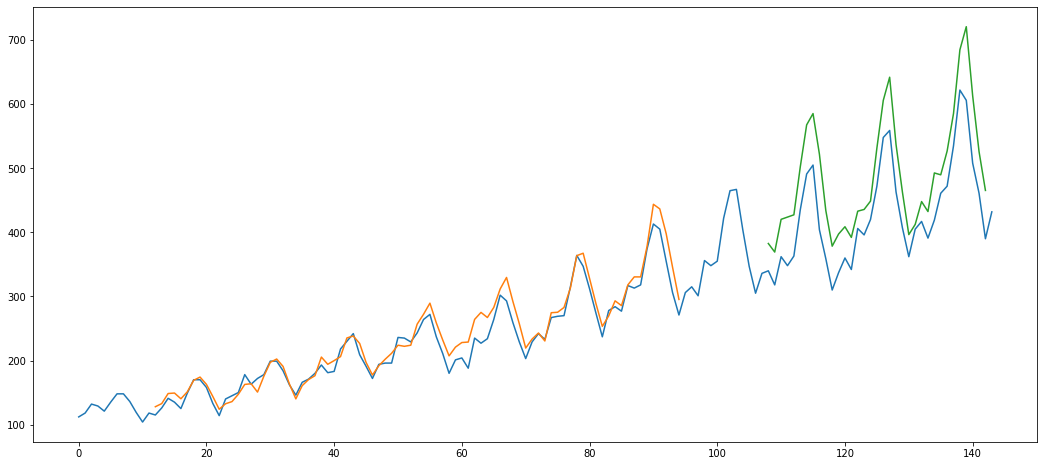

In [12]:
#畫訓練資料趨勢圖
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

#畫測試資料趨勢圖
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict

#畫原始資料趨勢圖
plt.plot(sc.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

In [13]:
#載入先前存取的最佳權重模型
model = load_model('./my_model.h5')

In [14]:
model.compile(loss = 'mse', optimizer = 'adam')

In [15]:
#再次載入原始資料並對載入的模型作進一步訓練
np.random.seed(7)

dataframe = pd.read_csv('international-airline-passengers.csv', parse_dates = ["Month"], index_col = ["Month"])
dataset = dataframe.values

sc = MinMaxScaler()
dataset = sc.fit_transform(dataset)

train_size = int(len(dataset)*0.67)
test_size = len(dataset)-train_size
train, test = dataset[0:train_size, :], dataset[train_size:, :]

look_back = 12
trainX, trainY = create_dataset(train, look_back)
testX, testY  = create_dataset(test, look_back)

trainX = np.reshape(trainX,(trainX.shape[0], trainX.shape[1], 1))
testX = np.reshape(testX,(testX.shape[0], testX.shape[1], 1))

mc = ModelCheckpoint("my_model.h5", monitor="loss",
                     mode="min", verbose=1,
                     save_best_only=True)
history = model.fit(trainX, trainY,
                    epochs=100, batch_size=10, verbose=1, callbacks=[mc])
model.save('./my_model.h5')

Epoch 1/100
83/83 [==============================] - 1s 13ms/step - loss: 0.0013

Epoch 00001: loss improved from inf to 0.00129, saving model to my_model.h5
Epoch 2/100
83/83 [==============================] - 0s 1ms/step - loss: 0.0012

Epoch 00002: loss improved from 0.00129 to 0.00125, saving model to my_model.h5
Epoch 3/100
83/83 [==============================] - 0s 1ms/step - loss: 9.2233e-04

Epoch 00003: loss improved from 0.00125 to 0.00092, saving model to my_model.h5
Epoch 4/100
83/83 [==============================] - 0s 1ms/step - loss: 8.3208e-04

Epoch 00004: loss improved from 0.00092 to 0.00083, saving model to my_model.h5
Epoch 5/100
83/83 [==============================] - 0s 1ms/step - loss: 8.3386e-04

Epoch 00005: loss did not improve from 0.00083
Epoch 6/100
83/83 [==============================] - 0s 1ms/step - loss: 8.0977e-04

Epoch 00006: loss improved from 0.00083 to 0.00081, saving model to my_model.h5
Epoch 7/100
83/83 [==============================] - 0

In [16]:
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

trainPredict = sc.inverse_transform(trainPredict)
trainY = sc.inverse_transform([trainY])
testPredict = sc.inverse_transform(testPredict)
testY = sc.inverse_transform([testY])

from sklearn.metrics import r2_score
score1 = r2_score(trainY[0], trainPredict[:, 0])
print('Train Score: %.2f' %score1)
score2 = r2_score(testY[0], testPredict[:, 0])
print('Test Score: %.2f' %score2)

Train Score: 0.96
Test Score: 0.91


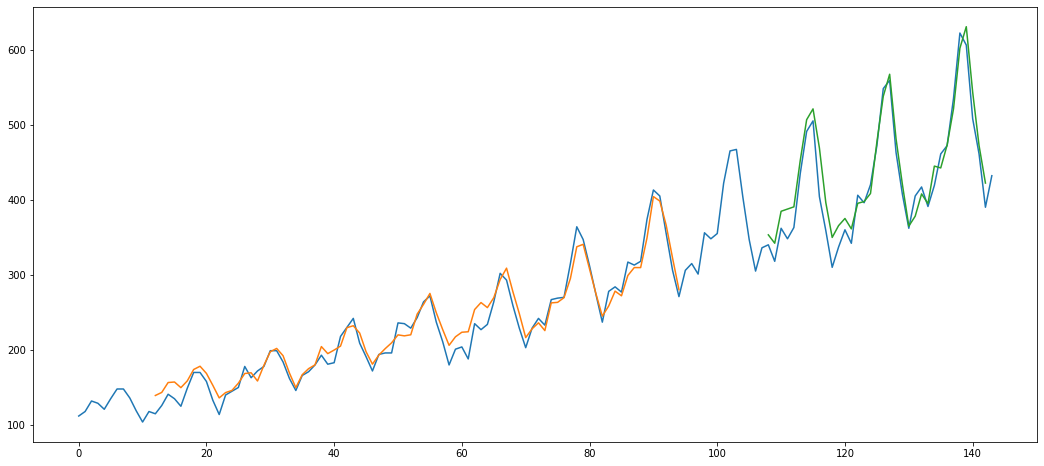

In [17]:
#畫訓練資料趨勢圖
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

#畫測試資料趨勢圖
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict

#畫原始資料趨勢圖
plt.plot(sc.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()